# Lecture : Weisfeiler-Lehman GNNs

## Lab 01 : GINs -- Solution

### Xavier Bresson, Jiaming Wang   

Xu, Hu, Leskovec, Jegelka, How powerful are graph neural networks, 2018   
https://arxiv.org/pdf/1810.00826.pdf


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/09_WL_GNNs'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    

In [2]:
# Libraries
import dgl
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut
import time


# Generate CSL dataset

The CSL dataset, introduced in [1], is a dataset to evaluate the graph isomorphism power of GNNs.  
This dataset requires a GNN to be at least as powerful as the 1-WL test to separate the classes.  

[1] Murphy et-al, Relational pooling for graph representations, 2019, https://arxiv.org/pdf/1903.02541


[Graph(num_nodes=7, num_edges=28,
      ndata_schemes={}
      edata_schemes={}), tensor(0)]


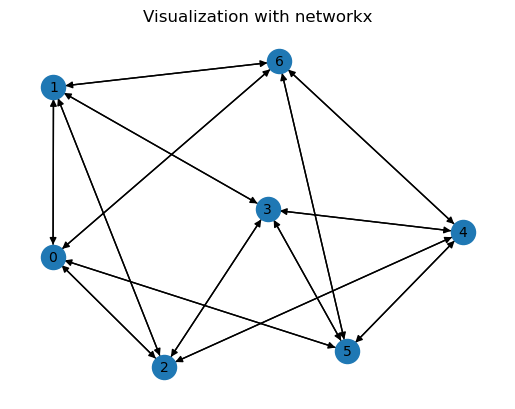

In [4]:
def generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class):
    label_class = 0
    list_graph = []
    # loop over skip values
    for skip_value in list_skip_value:
        # build CSL graph with node indexing in {0,1,...,num_nodes-1}
        list_src = []
        list_dst = []
        for i in range(num_nodes):
            # cycle
            list_src.append(i)
            list_dst.append((i+1)%num_nodes)
            # skip connection
            list_src.append(i)
            list_dst.append((i+skip_value)%num_nodes)
        graph = dgl.graph((list_src, list_dst)) # build DGL graph
        graph = dgl.to_bidirected(graph) # symmetrize/undirected graph
        list_graph.append([graph, torch.tensor(label_class).long()])
        for _ in range(num_graph_per_class-1): # build CSL graph with random node indexing
            idx_shuffle = torch.randperm(num_nodes).tolist() # random permutation of node indexing
            list_src = [idx_shuffle[i] for i in list_src]
            list_dst = [idx_shuffle[i] for i in list_dst]
            graph = dgl.graph((list_src, list_dst)) # build DGL graph
            graph = dgl.to_bidirected(graph) # symmetrize/undirected graph
            list_graph.append([graph, torch.tensor(label_class).long()])
        # increment class label
        label_class += 1
    return list_graph


# Generate small CSL graph
num_nodes = 7; list_skip_value = [2]; num_graph_per_class = 1
small_csl_graph = generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class)
print(small_csl_graph[0])
graph = small_csl_graph[0][0]
fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw(graph.to_networkx(), ax=ax, with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()

#CSL = cycle graphs with skip lists

# Generate train and test datasets 

## Add node feature

In [5]:
# Laplacian eigenvectors as positional encoding
def LapEig_positional_encoding(g, pos_enc_dim):
    Adj = g.adj().to_dense() # Adjacency matrix
    Dn = ( g.in_degrees()** -0.5 ).diag() # Inverse and sqrt of degree matrix
    Lap = torch.eye(g.number_of_nodes()) - Dn.matmul(Adj).matmul(Dn) # Laplacian operator
    EigVal, EigVec = torch.linalg.eig(Lap) # Compute full EVD
    EigVal, EigVec = EigVal.real, EigVec.real # make eig real
    EigVec = EigVec[:, EigVal.argsort()] # sort in increasing order of eigenvalues
    EigVec = EigVec[:,1:pos_enc_dim+1] # select the first non-trivial "pos_enc_dim" eigenvector
    return EigVec

# Add node and edge features to graphs
pos_enc_dim = 6 # dimension of PE
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['degree'] = graph.in_degrees().view(-1, 1).float() # node degree as node feature
        graph.ndata['random'] = torch.rand((graph.number_of_nodes(), pos_enc_dim)) # random features
        graph.ndata['index'] = torch.arange(graph.number_of_nodes()) # node index as node feature
        graph.ndata['pos_enc'] = LapEig_positional_encoding(graph, pos_enc_dim) # node positional encoding as node feature 
    return dataset

# Generate CSL datasets
num_nodes = 41
list_skip_value = [2, 3, 4, 5, 6, 9, 11, 12, 13, 16]
num_graph_per_class = 15
trainset = generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class)
testset = generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class)
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
print(trainset[0])


[Graph(num_nodes=41, num_edges=164,
      ndata_schemes={'degree': Scheme(shape=(1,), dtype=torch.float32), 'random': Scheme(shape=(6,), dtype=torch.float32), 'index': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={}), tensor(0)]


# Visualize positional encoding

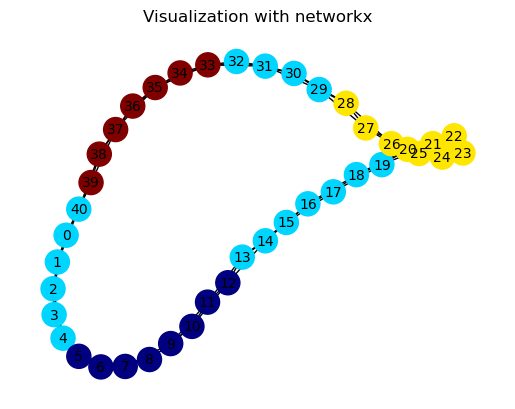

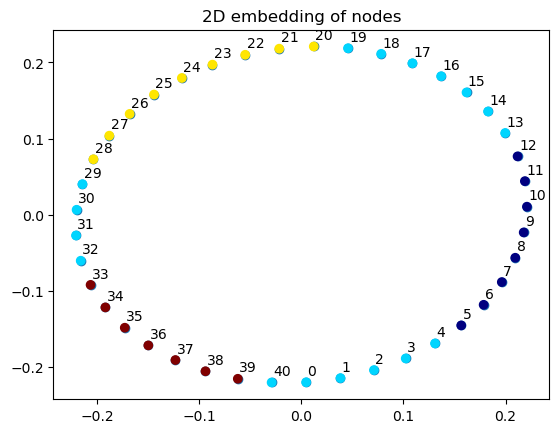

In [6]:
graph = trainset[0][0]

# Visualize graph
fig = plt.figure()
ax = fig.add_subplot(111)
Adj = graph.adj().to_dense()
A_nx = nx.from_numpy_array(Adj.numpy())
C = compute_ncut(Adj.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()

# Plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
x = graph.ndata['pos_enc']
ax.scatter(x[:,0], x[:,1]) #only viz 2/6 dims
idx = list(range(graph.number_of_nodes()))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embedding of nodes')
plt.show()


## Question 1: Define the collate function to prepare a batch of DGL graphs and test it

To speed up training, we typically process training data with mini-batches. 

PyTorch designed the general class `DataLoader()` to prepare batch of data, including DGL graphs.

It requires to re-define the `collate()` function that takes as input a list of training data in the form of tuples of <graph, label>, and outputs a batch of DGL graphs and labels from this list.

Hint: you need to use the [dgl.batch()](https://docs.dgl.ai/en/1.1.x/generated/dgl.batch.html) function.


In [6]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    ########################################
    # YOUR CODE STARTS
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels (here class label)
    # YOUR CODE ENDS
    ########################################
    return batch_graphs, batch_labels


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['degree']
print('batch_x:',batch_x.size())
batch_pe = batch_graphs.ndata['pos_enc']
print('batch_pe:',batch_pe.size())
 # also have index and random

Graph(num_nodes=410, num_edges=1640,
      ndata_schemes={'degree': Scheme(shape=(1,), dtype=torch.float32), 'random': Scheme(shape=(6,), dtype=torch.float32), 'index': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={})
tensor([7, 8, 9, 4, 7, 2, 6, 0, 6, 6])
batch_x: torch.Size([410, 1])
batch_pe: torch.Size([410, 6])


## Question 2: Design the class of Graph Isomorphism Networks (GIN) with DGL

### Implement the following node update equation with the node degree as input node feature:
\begin{eqnarray}
h_i^{\ell+1} &=& \textrm{MLP} \left( (1+\varepsilon^{\ell})\ h_i^{\ell} + \sum_{j\sim i} h_j^{\ell} \right) \\
h_i^{\ell=0} &=& d_i \textrm{ (node degree)}
\end{eqnarray}

Report the training loss and test loss.

Hints: You may use 
- `batch_graphs.ndata['degree']` to access the node degree.
- Function [`dgl.sum_nodes()`](https://docs.dgl.ai/en/0.2.x/generated/dgl.sum_nodes.html) to sum over all node features.



In [7]:
# MLP layer for classification
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):   
        ########################################
        # Process the input using the previously defined layers 
        # YOUR CODE STARTS 
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        # YOUR CODE ENDS
        ########################################
        return y

        
# class of GatedGCN layer  
class GIN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(GIN_layer, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim, bias=True)
        self.linear2 = nn.Linear(input_dim, output_dim, bias=True)
        ########################################
        # Define a learnable scalar parameter initialized to 0.001
        # You may use "nn.Parameter()"
        # YOUR CODE STARTS
        self.eps = nn.Parameter(torch.tensor(0.001)) # scalar, size=()
        # YOUR CODE ENDS
        ########################################
          
    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges):
        hj = edges.src['h'] 
        return {'hj' : hj}

    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={hj} sent to node dst/i with Step 1
    def reduce_func(self, nodes):
        hj = nodes.mailbox['hj'] # size=(V,|Nj|,d), |Nj|=num_neighbors
        ########################################
        # Compute hi = sum_j hj
        # YOUR CODE STARTS
        sum_hj = torch.sum( hj, dim=1 ) # hi = sum_j hj, size=(V,d)
        # YOUR CODE ENDS
        ########################################
        return {'sum_hj' : sum_hj} 
    
    def forward(self, g, h):
        g.ndata['h'] = h 
        g.update_all(self.message_func,self.reduce_func) # update the node feature with DGL
        ########################################
        # Compute GIN node update 
        # You may use "nn.Linear()", "torch.relu()"
        # YOUR CODE STARTS
        h = (1 + self.eps) * h + g.ndata['sum_hj'] # size=(V,d)
        h = self.linear2(torch.relu(self.linear1(h))) # size=(V,d)
        # YOUR CODE ENDS
        ########################################
        return h
    
    
class GIN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GIN_net, self).__init__()
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        degree_dim = 1
        self.embedding_h = nn.Linear(degree_dim, hidden_dim) # node degree as node feature
        self.GIN_layers = nn.ModuleList([ GIN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # GIN layers
        for GINlayer in self.GIN_layers:
            h = GINlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.sum_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    


def accuracy(scores, targets):
    scores = scores.detach().argmax(dim=1)
    acc = (scores==targets).float().sum().item()
    return acc


# Instantiate one network (testing)
net_parameters = {}
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
net = GIN_net(net_parameters)
print(net)


GIN_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (GIN_layers): ModuleList(
    (0-3): 4 x GIN_layer(
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
  )
)


In [8]:
def run_one_epoch(net, data_loader, lossCE, train=True, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        ########################################
        # YOUR CODE STARTS
        batch_x = batch_graphs.ndata['degree'] # node degree as node feature
        # YOUR CODE ENDS
        ######################################## 
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = lossCE(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc, optimizer


# dataset loaders
train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=10, shuffle=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
del net
net = GIN_net(net_parameters)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# loss, optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
num_epochs = 51
for epoch in range(num_epochs): 
    epoch_train_loss, epoch_train_acc, optimizer = run_one_epoch(net, train_loader, loss, True, optimizer)
    if not epoch%10:
        with torch.no_grad(): 
            epoch_test_loss, epoch_test_acc, _ = run_one_epoch(net, test_loader, loss, False)
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))
        print('                       train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc))
    

Number of parameters: 661006 (0.66 million)


/Users/xbresson/miniconda3/envs/gnn_course/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0, time 1.0154, train_loss: 10.3035, test_loss: 3.3969
                       train_acc: 0.1000, test_acc: 0.1000
Epoch 10, time 7.9592, train_loss: 2.6803, test_loss: 2.7839
                       train_acc: 0.0933, test_acc: 0.1000
Epoch 20, time 15.1207, train_loss: 2.5656, test_loss: 2.5170
                       train_acc: 0.1000, test_acc: 0.1000
Epoch 30, time 25.9630, train_loss: 2.4518, test_loss: 2.4610
                       train_acc: 0.0533, test_acc: 0.1000
Epoch 40, time 33.9876, train_loss: 2.3789, test_loss: 2.5032
                       train_acc: 0.1267, test_acc: 0.1000
Epoch 50, time 42.5405, train_loss: 2.3626, test_loss: 2.3372
                       train_acc: 0.0800, test_acc: 0.1000


## Question 3: Design GIN with random feature as input node feature

\begin{eqnarray}
h_i^{\ell+1} &=& \textrm{MLP} \left( (1+\varepsilon^{\ell})\ h_i^{\ell} + \sum_{j\sim i} h_j^{\ell} \right) \\
h_i^{\ell=0} &=& \mathcal{N}_i \textrm{ (random features)}
\end{eqnarray}

Report the training loss and test loss.

Hint: You may use `batch_graphs.ndata['random']` to access random node feature.



In [9]:
class GIN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GIN_net, self).__init__()
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        ########################################
        # YOUR CODE STARTS
        self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # random features
        # YOUR CODE ENDS
        ########################################   
        self.GIN_layers = nn.ModuleList([ GIN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # GIN layers
        for GINlayer in self.GIN_layers:
            h = GINlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.sum_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    

def run_one_epoch(net, data_loader, lossCE, train=True, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        ########################################
        # YOUR CODE STARTS
        batch_x = batch_graphs.ndata['random'] # random features
        # YOUR CODE ENDS
        ######################################## 
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = lossCE(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc, optimizer


# dataset loaders
train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=10, shuffle=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
del net
net = GIN_net(net_parameters)
_ = display_num_param(net)

# loss, optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
num_epochs = 101
for epoch in range(num_epochs): 
    epoch_train_loss, epoch_train_acc, optimizer = run_one_epoch(net, train_loader, loss, True, optimizer)
    if not epoch%10:
        with torch.no_grad(): 
            epoch_test_loss, epoch_test_acc, _ = run_one_epoch(net, test_loader, loss, False)
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc))




Number of parameters: 662286 (0.66 million)
Epoch 0, time 0.9564, train_loss: 2.8152, test_loss: 2.3467
                      train_acc: 0.0867, test_acc: 0.1000
Epoch 10, time 13.1063, train_loss: 2.3041, test_loss: 2.3152
                      train_acc: 0.1267, test_acc: 0.1067
Epoch 20, time 21.2545, train_loss: 2.2410, test_loss: 2.4125
                      train_acc: 0.1600, test_acc: 0.1067
Epoch 30, time 28.8630, train_loss: 2.1905, test_loss: 2.3577
                      train_acc: 0.1867, test_acc: 0.1067
Epoch 40, time 39.7789, train_loss: 1.8120, test_loss: 2.5939
                      train_acc: 0.3267, test_acc: 0.0867
Epoch 50, time 53.2836, train_loss: 1.6545, test_loss: 2.8815
                      train_acc: 0.4333, test_acc: 0.1733
Epoch 60, time 60.0824, train_loss: 0.6267, test_loss: 3.5767
                      train_acc: 0.8133, test_acc: 0.1800
Epoch 70, time 69.5265, train_loss: 0.6479, test_loss: 4.8536
                      train_acc: 0.7933, test_acc: 0.193

## Question 4: Design GIN with node index as input node feature

\begin{eqnarray}
h_i^{\ell+1} &=& \textrm{MLP} \left( (1+\varepsilon^{\ell})\ h_i^{\ell} + \sum_{j\sim i} h_j^{\ell} \right) \\
h_i^{\ell=0} &=& i \textrm{ (node index)}
\end{eqnarray}

Report the training loss and test loss.

Hint: You may use `batch_graphs.ndata['index']` to access node index.



In [10]:
class GIN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GIN_net, self).__init__()
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        ########################################
        # YOUR CODE STARTS
        self.embedding_h = nn.Embedding(num_nodes, hidden_dim) # node index as node feature
        # YOUR CODE ENDS
        ########################################       
        self.GIN_layers = nn.ModuleList([ GIN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # GIN layers
        for GINlayer in self.GIN_layers:
            h = GINlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.sum_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    

def run_one_epoch(net, data_loader, lossCE, train=True, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        ########################################
        # YOUR CODE STARTS
        batch_x = batch_graphs.ndata['index'] # node index as node feature
        # YOUR CODE ENDS
        ######################################## 
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = lossCE(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc, optimizer


# dataset loaders
train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=10, shuffle=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
del net
net = GIN_net(net_parameters)
_ = display_num_param(net)

# loss, optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
num_epochs = 51
for epoch in range(num_epochs): 
    epoch_train_loss, epoch_train_acc, optimizer = run_one_epoch(net, train_loader, loss, True, optimizer)
    if not epoch%10:
        with torch.no_grad(): 
            epoch_test_loss, epoch_test_acc, _ = run_one_epoch(net, test_loader, loss, False)
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc))




Number of parameters: 670990 (0.67 million)
Epoch 0, time 1.3412, train_loss: 2.7164, test_loss: 2.5142
                      train_acc: 0.1133, test_acc: 0.0800
Epoch 10, time 13.7503, train_loss: 0.9854, test_loss: 2.4733
                      train_acc: 0.7067, test_acc: 0.1667
Epoch 20, time 22.5940, train_loss: 0.0138, test_loss: 2.9895
                      train_acc: 1.0000, test_acc: 0.2000
Epoch 30, time 31.7862, train_loss: 0.0032, test_loss: 3.3223
                      train_acc: 1.0000, test_acc: 0.2000
Epoch 40, time 42.4387, train_loss: 0.0013, test_loss: 3.4686
                      train_acc: 1.0000, test_acc: 0.2067
Epoch 50, time 52.8745, train_loss: 0.0007, test_loss: 3.6497
                      train_acc: 1.0000, test_acc: 0.2067


## Question 5: Design GIN with positional encoding as input node feature

\begin{eqnarray}
h_i^{\ell+1} &=& \textrm{MLP} \left( (1+\varepsilon^{\ell})\ h_i^{\ell} + \sum_{j\sim i} h_j^{\ell} \right) \\
h_i^{\ell=0} &=& i \textrm{ (node positional encoding, here Laplacian eigenvectors)}
\end{eqnarray}

Report the training loss and test loss.

Hint: You may use `batch_graphs.ndata['pos_enc']` to access node index.



In [11]:
class GIN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GIN_net, self).__init__()
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        ########################################
        # YOUR CODE STARTS
        self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # node positional encoding as node feature 
        # YOUR CODE ENDS
        ########################################   
        self.GIN_layers = nn.ModuleList([ GIN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # GIN layers
        for GINlayer in self.GIN_layers:
            h = GINlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.sum_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    

def run_one_epoch(net, data_loader, lossCE, train=True, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        ########################################
        # YOUR CODE STARTS
        batch_pe = batch_graphs.ndata['pos_enc']
        # YOUR CODE ENDS
        ########################################    
        batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        batch_x = batch_pe # node positional encoding as node feature 
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = lossCE(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc, optimizer


# dataset loaders
train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=10, shuffle=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
del net
net = GIN_net(net_parameters)
_ = display_num_param(net)

# loss, optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)

# training loop
start = time.time()
num_epochs = 201
for epoch in range(num_epochs): 
    epoch_train_loss, epoch_train_acc, optimizer = run_one_epoch(net, train_loader, loss, True, optimizer)
    if not epoch%10:
        with torch.no_grad(): 
            epoch_test_loss, epoch_test_acc, _ = run_one_epoch(net, test_loader, loss, False)
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc))



Number of parameters: 662286 (0.66 million)
Epoch 0, time 0.8954, train_loss: 2.8348, test_loss: 2.4293
                      train_acc: 0.1067, test_acc: 0.1000
Epoch 10, time 10.7576, train_loss: 2.2406, test_loss: 2.1766
                      train_acc: 0.1533, test_acc: 0.1200
Epoch 20, time 26.0811, train_loss: 1.8943, test_loss: 1.7645
                      train_acc: 0.2533, test_acc: 0.2067
Epoch 30, time 36.6138, train_loss: 1.3028, test_loss: 1.0830
                      train_acc: 0.3867, test_acc: 0.5533
Epoch 40, time 43.2259, train_loss: 0.7806, test_loss: 0.6911
                      train_acc: 0.7000, test_acc: 0.7267
Epoch 50, time 52.5932, train_loss: 0.9133, test_loss: 1.7431
                      train_acc: 0.4867, test_acc: 0.2067
Epoch 60, time 61.3828, train_loss: 0.7167, test_loss: 0.4573
                      train_acc: 0.6333, test_acc: 0.7733
Epoch 70, time 69.7314, train_loss: 0.5223, test_loss: 0.5160
                      train_acc: 0.7267, test_acc: 0.666

## Question 6: Understand the results

| GIN feature    | train acc | test acc |
| -------- | ------- | ------- |
| Node degree  | 0.0667   | 0.1000    |
| Random feature | 1.0000     | 0.2067     |
| Node index    | 1.0000    | 0.2667    |
| Node positional encoding    | 1.0000    | 1.0000    |
